In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


(1080, 1920)


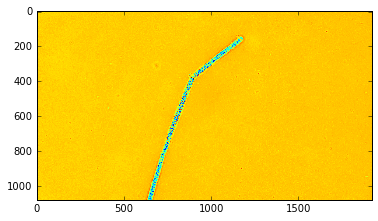

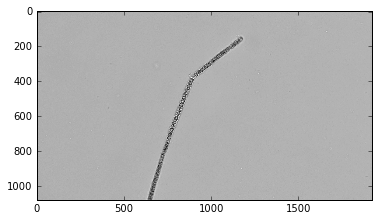

In [68]:
imageNames = ["planktothrix_80_6h_19.tif", "planktothrix_80_6h_32.tif", "planktothrix_before_22.tif", "planktothrix_before_23.tif"]
img = cv2.imread(imageNames[0],0)
print(img.shape)
normalizedImg = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
img = normalizedImg
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
plt.imshow(img_rgb)
plt.show()

**High Pass Filter**

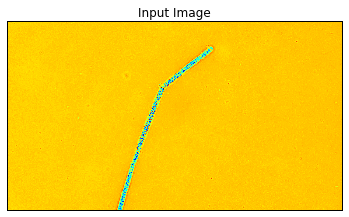

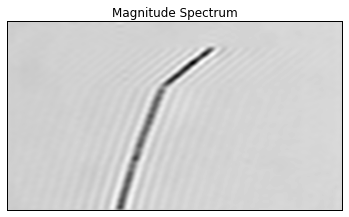

In [69]:
def hp_filter(img):
    img_float32 = np.float32(img)

    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    rows, cols = img.shape
    crow, ccol = rows/2 , cols/2     # center

    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    mask2 = np.zeros((rows, cols, 2), np.uint8)
    mask2[np.where(mask == 0)] = 1
    #mask = mask2

    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
    return img_back

img_back = hp_filter(img)
plt.imshow(img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()                

Morphological operations

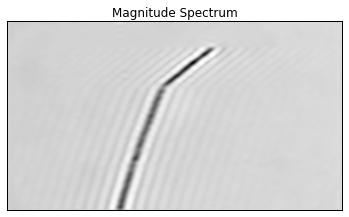

In [70]:
kernel = np.ones((5,5),np.uint8)
#kernel = [[0,0,0,0,0],[0,1,1,1,0],[0,1,2,1,0],[0,1,1,1,0],[0,0,0,0,0]]
erosion = cv2.erode(img_back,kernel,iterations = 1)
dilation = cv2.dilate(erosion,kernel,iterations = 2)
plt.imshow(dilation, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()                

(2073600,)
mean = 365702720.0
median = 367392576.0
threshold = 352236320.0


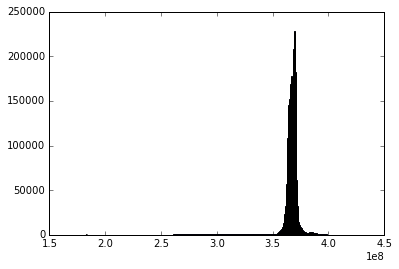

In [75]:
myData = img_back.flatten()
print(myData.shape)
numBins = 255
n, bins, patches = plt.hist(myData, numBins, facecolor='blue')
myMean = np.mean(myData)
myMedian = np.median(myData)
myStd = np.std(myData)
myThres = myMean - (myStd)
print("mean = {}".format(myMean))
print("median = {}".format(myMedian))
print("threshold = {}".format(myThres))
plt.show()

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


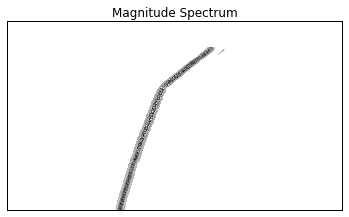

In [72]:
threshold = 3.5e+08
upper = 255
img_filtered = np.where(img_back>threshold, upper, img)
print(img_filtered)
plt.imshow(img_filtered, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()    

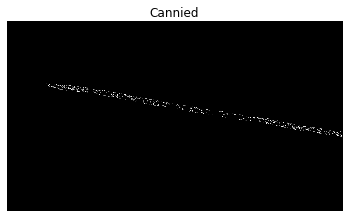

In [27]:
img_cannied = cv2.Canny(img, 100, 200)
img_cannied_rgb = cv2.cvtColor(img_cannied, cv2.COLOR_BGR2RGB)
plt.imshow(img_cannied_rgb)
plt.title('Cannied'), plt.xticks([]), plt.yticks([])
plt.show()

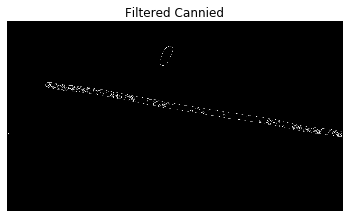

In [52]:
img_filtered_cannied = cv2.Canny(img_filtered, 256, 50, 5)
img_filtered_cannied_rgb = cv2.cvtColor(img_filtered_cannied, cv2.COLOR_BGR2RGB)
plt.imshow(img_filtered_cannied_rgb)
plt.title('Filtered Cannied'), plt.xticks([]), plt.yticks([])
plt.show()

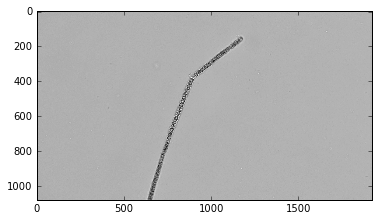

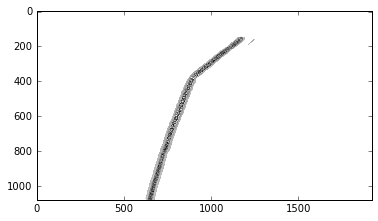

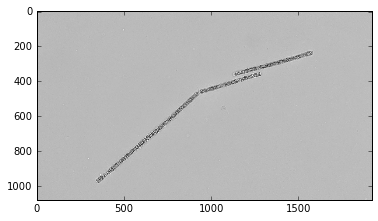

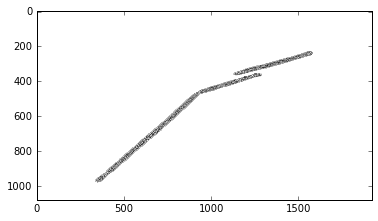

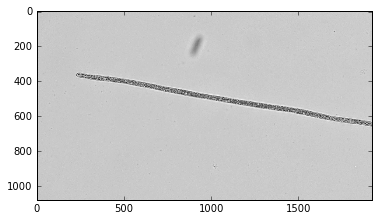

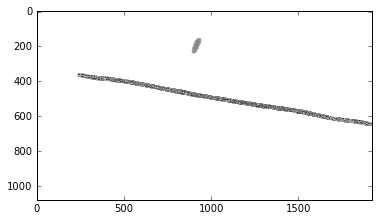

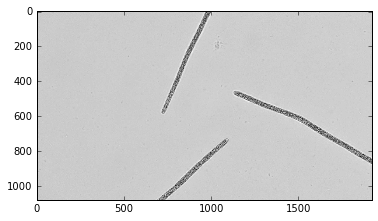

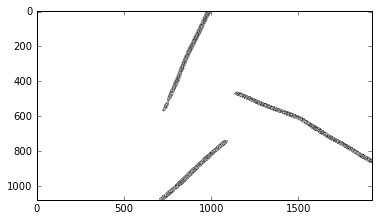

In [78]:
def customFilter(img):
    img_back = hp_filter(img)
    myData = img_back.flatten()
    threshold = 3.5e+08
    myMean = np.mean(myData)
    myStd = np.std(myData)
    myThres = myMean - (2*myStd)
    #threshold = myThres
    upper = 255
    img_filtered = np.where(img_back>threshold, upper, img)
    return img_filtered

imageNames = ["planktothrix_80_6h_19.tif", "planktothrix_80_6h_32.tif", "planktothrix_before_22.tif", "planktothrix_before_23.tif"]
for i in imageNames:
    img = cv2.imread(i,0)
    normalizedImg = cv2.normalize(img,  None, 0, 255, cv2.NORM_MINMAX)
    img = normalizedImg
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    img_f = customFilter(img)
    img_f_rgb = cv2.cvtColor(img_f, cv2.COLOR_BGR2RGB)
    plt.imshow(img_f_rgb)
    plt.show()

    